In [160]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

Импорт всего и вся и разные функции перевода строка/числа/батч/тензор и т.п.

In [507]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
from pathlib import Path
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.nn import Module
from torchinfo import summary
import pytorch_lightning as pl
from torchvision import transforms
from torchmetrics import CharErrorRate
from skimage.draw import line_aa
from random import randint
import pandas as pd

<IPython.core.display.Javascript object>

In [162]:
# ячейка скопирована из документации torchvision https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional


plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20, 10))
    for i, img in enumerate(imgs):
        img = img.type(torch.uint8).detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img) * 255)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

<IPython.core.display.Javascript object>

In [497]:
seq_len = 5
alphabet = set(
    letter
    for path in Path("samples").glob("*.png")
    for letter in str(path).split("/")[1].split(".")[0]
)
print(alphabet)

{'c', 'f', '4', 'w', 'y', 'p', '7', 'x', '8', 'n', 'g', '6', 'b', '5', 'm', '3', 'e', 'd', '2'}


<IPython.core.display.Javascript object>

In [164]:
char_to_idx = {letter: idx for idx, letter in enumerate(alphabet)}
idx_to_char = {idx: letter for idx, letter in enumerate(alphabet)}

<IPython.core.display.Javascript object>

In [496]:
def create_tensors() -> dict[str, torch.Tensor]:
    matrix = F.one_hot(torch.tensor(list(char_to_idx.values()), dtype=int))
    return (
        {letter: matrix[idx] for idx, letter in enumerate(alphabet)},
        {tuple(matrix[idx].tolist()): letter for idx, letter in enumerate(alphabet)},
    )


char_to_tensor, tensor_to_char = create_tensors()
# char_to_tensor, tensor_to_char

<IPython.core.display.Javascript object>

In [166]:
def word_to_tensor(word: str) -> torch.Tensor:
    return torch.stack([char_to_tensor[char] for char in word])


def tensor_to_word(word: torch.Tensor) -> str:
    return "".join([tensor_to_char[tuple(char)] for char in word.tolist()])


word_to_tensor("w3c"), tensor_to_word(word_to_tensor("w3c"))

(tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'w3c')

<IPython.core.display.Javascript object>

In [167]:
def batch_to_tensor(batch: list[str]) -> torch.Tensor:
    return torch.stack([word_to_tensor(w) for w in batch])


def tensor_batch_to_batch(batch: torch.Tensor) -> list[str]:
    return [tensor_to_word(w) for w in batch]


def idx_list_to_word(idxs: list[int]) -> str:
    return "".join([idx_to_char[i] for i in idxs])


batch_to_tensor(["w3c", "md5"]), tensor_batch_to_batch(batch_to_tensor(["w3c", "md5"]))

(tensor([[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]]),
 ['w3c', 'md5'])

<IPython.core.display.Javascript object>

In [434]:
batch_size = 32
train_increase = 3

<IPython.core.display.Javascript object>

К датасету была применена аугментация, т.к. исходно он довольно мал (~800 объектов на train). А именно: шумы (в итоге не использовал, но код оставил) и смещение. Помимо этого был убран фон и RGB преобразовано в битовую маску.

['p4pde', 'y866y', 'w6pxy', 'y2ye8', '33n73', '2mpnn', 'f7cey', 'cnmnn', 'cdfen', '23mdg', 'ny3dw', 'ggd7m', 'xbcbx', 'y4g3b', 'wye85', '3nfdn', 'w8bnx', 'xf4p4', 'xw465', '6cwxe', 'm448b', '6wnyc', 'ppwyd', '5ep3n', '5pm6b', 'ypp8f', 'yfdn7', 'yd38e', 'b84xc', 'm8gmx', 'g842c', 'wnpec']


(torch.Size([32, 1, 50, 200]), torch.Size([32, 5, 19]))

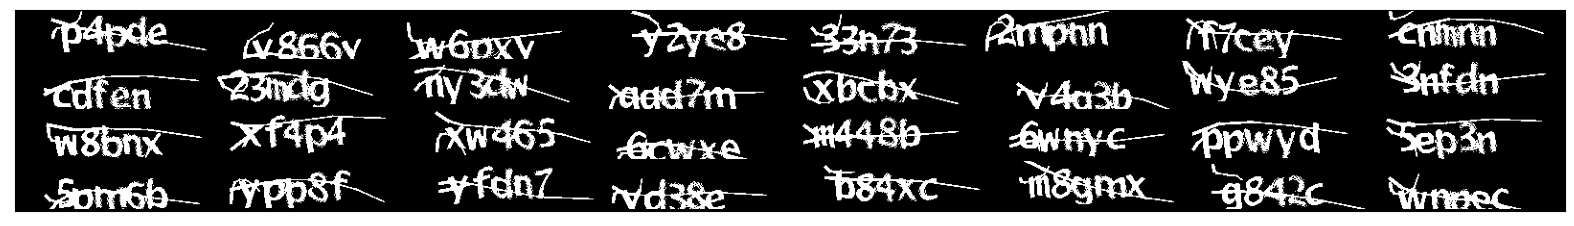

<IPython.core.display.Javascript object>

In [435]:
class CapchaSet(Dataset):
    def __init__(self, files: list[Path], noise_enable=False, offset_enable=False):
        self.files = files
        self.noise_enable = noise_enable
        self.offset_enable = offset_enable

    @staticmethod
    def gen_files(folder_path: Path):
        assert folder_path.is_dir()
        return list(folder_path.glob("*.png"))

    def __len__(self):
        return len(self.files) * train_increase

    def __getitem__(self, idx: int):
        idx //= train_increase
        path = str(self.files[idx])
        name = path.split("/")[1].split(".")[0]
        name = word_to_tensor(name).type(torch.float)
        img = read_image(path)[0, None]
        img = (img < 100).type(torch.float)
        if self.offset_enable:
            img = transforms.RandomAffine(degrees=0, translate=(0.1, 0.2))(img)
        if self.noise_enable:
            img += (
                torch.normal(
                    mean=torch.normal(mean=-0.5, std=torch.tensor(0.5)).minimum(
                        torch.tensor(0.05)
                    ),
                    std=torch.ones(img[0].shape),
                )
                > 0
            )
            line_counts = randint(1, 5)
            for _ in range(line_counts):
                rr, cc, _ = line_aa(
                    randint(0, 49), randint(0, 49), randint(0, 49), randint(150, 199)
                )
                img[0, rr, cc] = 1.0

        return img, name


check_set = CapchaSet(
    files=CapchaSet.gen_files(Path("samples")),
    noise_enable=True,
    offset_enable=True,
)
check_set.noise_enable = False
it = iter(
    DataLoader(
        check_set,
        batch_size=batch_size,
        shuffle=True,
    )
)
inp, outp = next(it)
print(tensor_batch_to_batch(outp))
show(make_grid(inp))
inp.shape, outp.shape

Деление датасета и применение аугментации к train

['bdg84', 'pwn5e', '6pwcn', 'cfn53', 'mx8bb', '4n2yg', 'gnbde', 'w4x2m', '38n57', 'e72cd', '3ebnn', '5np4m', 'n4wwn', 'be6np', 'n373n', '8gmc4', 'mcg43', '5n732', 'ymp7g', 'xngxc', '2nbcx', 'p6mn8', 'efb3f', '377xx', 'nmy2x', 'pf4nb', '6ydyp', '6dd2y', 'nxn4f', 'fncnb', '7cgym', 'g6n7x']


(torch.Size([32, 1, 50, 200]), torch.Size([32, 5, 19]), 728, 2184)

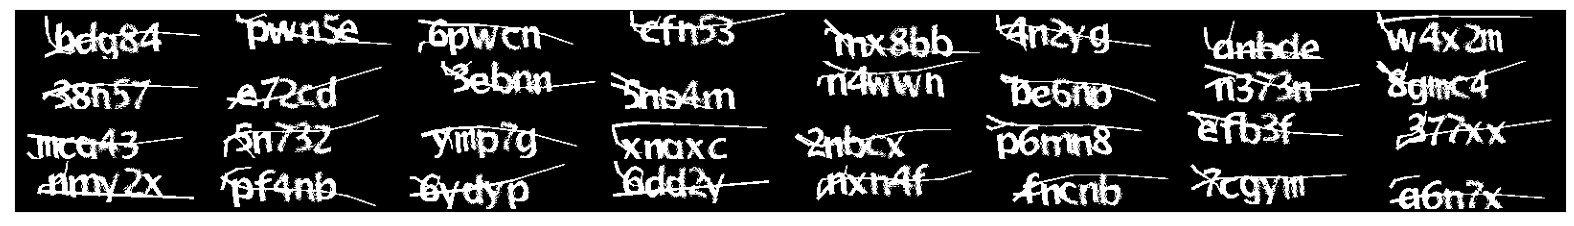

<IPython.core.display.Javascript object>

In [436]:
torch.manual_seed(0)
train_files, val_files, test_files = random_split(
    CapchaSet.gen_files(folder_path=Path("samples")), (0.7, 0.1, 0.2)
)
train_set, val_set, test_set = (
    CapchaSet(train_files, offset_enable=True),
    CapchaSet(val_files),
    CapchaSet(test_files),
)

it = iter(
    DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
    )
)
inp, outp = next(it)
print(tensor_batch_to_batch(outp))
show(make_grid(inp))
inp.shape, outp.shape, len(train_files), len(train_set)

Модель, как было предложено в задании, представляет из себя RCNN->LSTM->FC->Classificator

In [490]:
class CapchaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=(3, 3),
                stride=2,
                bias=False,
            ),
            nn.ReLU(),
        )
        self.cnn2 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(3, 3),
                stride=2,
                bias=False,
            ),
            nn.ReLU(),
        )
        self.cnn3 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(3, 3),
                stride=2,
                bias=False,
            ),
            nn.ReLU(),
        )
        self.cnn4 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(4, 5),
                stride=2,
                bias=False,
            ),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
        )
        self.lstm1 = nn.Sequential(
            nn.LayerNorm(512),
            nn.LSTM(
                input_size=512,
                hidden_size=256,
                num_layers=1,
                bidirectional=True,
                bias=False,
                batch_first=True,
            ),
        )
        self.fc1 = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Linear(
                in_features=512,
                out_features=len(alphabet),
                bias=False,
            ),
        )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, out: torch.Tensor):
        out = self.cnn1(out)
        out = self.cnn2(out)
        out = self.cnn3(out)
        out = self.cnn4(out)
        out = out.squeeze(2)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm1(out)
        out = out.reshape((-1, 512))
        out = self.fc1(out)
        out = self.classifier(out)
        out = out.view(-1, seq_len, len(alphabet))
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = self(x)
        loss = self.criterion(x, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = self(x)
        loss = self.criterion(x, y)
        self.log("val_loss", loss)
        return loss

    def validation_epoch_end(self, *args, **kwargs):
        super().validation_epoch_end(*args, **kwargs)
        self.log("val_cer", calc_cer(self, val_set))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


model = CapchaModel()
summary(model, inp.shape), model(inp).shape

(==========================================================================================
 Layer (type:depth-idx)                   Output Shape              Param #
 CapchaModel                              [32, 5, 19]               --
 ├─Sequential: 1-1                        [32, 64, 24, 99]          --
 │    └─BatchNorm2d: 2-1                  [32, 1, 50, 200]          2
 │    └─Conv2d: 2-2                       [32, 64, 24, 99]          576
 │    └─ReLU: 2-3                         [32, 64, 24, 99]          --
 ├─Sequential: 1-2                        [32, 128, 11, 49]         --
 │    └─BatchNorm2d: 2-4                  [32, 64, 24, 99]          128
 │    └─Conv2d: 2-5                       [32, 128, 11, 49]         73,728
 │    └─ReLU: 2-6                         [32, 128, 11, 49]         --
 ├─Sequential: 1-3                        [32, 256, 5, 24]          --
 │    └─BatchNorm2d: 2-7                  [32, 128, 11, 49]         256
 │    └─Conv2d: 2-8                       [32

<IPython.core.display.Javascript object>

In [498]:
def calc_cer(model, dataset):
    cer = 0
    with torch.no_grad():
        model.eval()
        for x, y in DataLoader(dataset, batch_size=batch_size):
            res = model(x)
            cer += (output_to_batch_idxs(res) != label_to_batch_idxs(y)).sum()
    cer = float(cer)
    cer /= len(dataset) * seq_len
    return cer


def output_to_batch_idxs(out: torch.Tensor):
    return torch.tensor(
        [
            nn.functional.softmax(out[b], dim=1).max(dim=1).indices.tolist()
            for b in range(out.shape[0])
        ]
    )


def output_to_batch_words(out: torch.Tensor):
    return [
        idx_list_to_word(
            nn.functional.softmax(out[b], dim=1).max(dim=1).indices.tolist()
        )
        for b in range(out.shape[0])
    ]


def label_to_batch_idxs(out: torch.Tensor):
    return torch.tensor(
        [out[b].max(dim=1).indices.tolist() for b in range(out.shape[0])]
    )

<IPython.core.display.Javascript object>

Попробовал использовать PyTorch Lightning - удобно. Для логов использовал tensorboard, поэтому графики прикрепил скринами

In [ ]:
trainer = pl.Trainer(logger=pl.loggers.TensorBoardLogger(save_dir="logs"))
trainer.fit(
    model,
    DataLoader(train_set, batch_size=batch_size, shuffle=True),
    DataLoader(val_set, batch_size=batch_size, shuffle=True),
)

В итоге на тесте получил CER=5.8%. Перепробовал очень много моделей, но остановился на данном результате.

cer=0.057692307692307696
['pcpg6', 'pmf5w', '3wnd3', 'd3c7y', 'd4ppy', 'm22e3', 'yf424', 'dbny3', 'my84e', 'n3m6x', 'x458w', '7m8px', 'c6745', 'nxx25', 'cb8cf', '8cm46', '3eny7', 'n3m6x', 'nwg2m', 'f858x', '6bxwg', '5nxnn', '8c2wy', 'wye85', '6g45w', '8c2wy', '33n73', '42nxy', 'd75b5', 'dbex3', 'my84e', 'd75b5']


(torch.Size([32, 1, 50, 200]), torch.Size([32, 5, 19]))

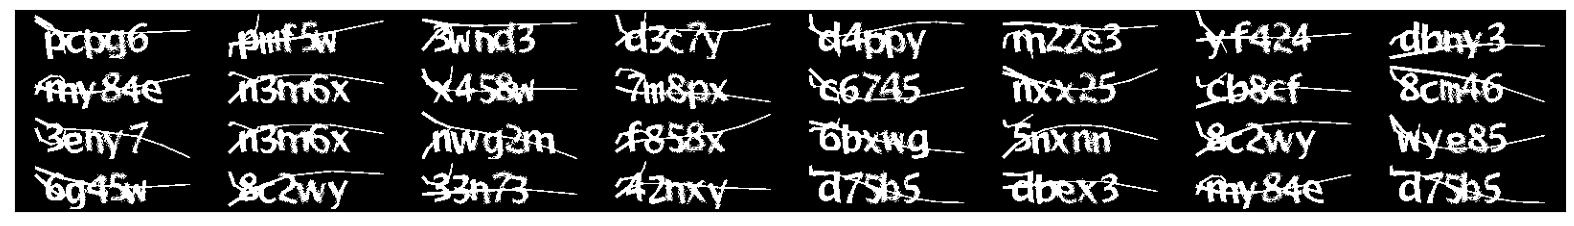

<IPython.core.display.Javascript object>

In [505]:
check_set = test_set
cer = calc_cer(model, check_set)
print(f"{cer=}")

inp, outp = next(iter(DataLoader(check_set, batch_size=batch_size, shuffle=True)))
print(tensor_batch_to_batch(outp))
show(make_grid(inp))
inp.shape, outp.shape

Пример батча. Видно, что в некоторых словах есть ошибки в одной букве: b/p, m/w, p/n, x/y, d/4, m/n

In [508]:
pd.DataFrame(
    [
        (pred, y, pred == y)
        for pred, y in [
            (
                idx_list_to_word(
                    nn.functional.softmax(model(inp)[b], dim=1)
                    .max(dim=1)
                    .indices.tolist()
                ),
                tensor_to_word(outp[b]),
            )
            for b in range(inp.shape[0])
        ]
    ],
    columns=["Prediction", "Label", "Equal"],
)

,Prediction,Label,Equal
0,bcpg6,pcpg6,False
1,nmf5m,pmf5w,False
2,3wpd3,3wnd3,False
3,d3c7y,d3c7y,True
4,d4ppy,d4ppy,True
5,m22e3,m22e3,True
6,yf424,yf424,True
7,dbpx3,dbny3,False
8,my84e,my84e,True
9,n3m6x,n3m6x,True


<IPython.core.display.Javascript object>

CER на данном батче

In [510]:
cer = CharErrorRate()
cer(output_to_batch_words(model(inp)), tensor_batch_to_batch(outp))

tensor(0.0750)

<IPython.core.display.Javascript object>